In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

from pysteps.postprocessing.ensemblestats import excprob
from pysteps.visualization import get_colormap
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from pincast_verif.nowcast_plot_tools import plot_image_grid
import pincast_verif.io_tools as io

In [3]:
SAVE = False
DATA_FOLDER = Path("../data")
OUTPUT_FOLDER = DATA_FOLDER / "figures" / "review"

dbs = [
    DATA_FOLDER / "deuce_nowcasts" / "review" / "deuce_long_preds.hdf5",
    DATA_FOLDER / "deuce_nowcasts" / "review" / "deuce_with_weight_preds.hdf5",
    #DATA_FOLDER / "deuce_nowcasts" / "review" / "deuce_baseline_preds.hdf5",
    DATA_FOLDER / "deuce_nowcasts" / "deuce-combined.hdf5",
    DATA_FOLDER / "baseline_nowcasts" / "measurements.hdf5",
]

case_timestamp = "2019-05-25 13:00:00"

In [4]:
metadata = [io.get_hdf5_metadata(db_path=dbs[i]) for i in range(len(dbs))]

long = io.load_predictions(
    db_path=dbs[0],
    time_0=case_timestamp,
    leadtimes=metadata[0]["leadtimes"],
    method_name=metadata[0]["method_name"]
    )
obses = io.load_observations(
    db_path=dbs[-1],
    time_0=case_timestamp,
    leadtimes=metadata[0]["leadtimes"],
    method_name=metadata[-1]["method_name"]
)
weight = io.load_predictions(
    db_path=dbs[1],
    time_0=case_timestamp,
    leadtimes=metadata[1]["leadtimes"],
    method_name=metadata[1]["method_name"]
    )
deuce = io.load_predictions(
    db_path=dbs[2],
    time_0=case_timestamp,
    leadtimes=metadata[2]["leadtimes"],
    method_name=metadata[2]["method_name"]
    )
inputs = io.load_observations(
    db_path=dbs[-1],
    time_0=case_timestamp,
    leadtimes=range(-12,0),
    method_name=metadata[-1]["method_name"]
)

In [5]:
weight.shape

(12, 48, 512, 512)

In [6]:
deuce_mean = deuce.mean(axis=1)
deuce_std = deuce.std(axis=1)

long_mean = long.mean(axis=1)
long_std = long.std(axis=1)

weight_mean = weight.mean(axis=1)
weight_std = weight.std(axis=1)

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj

def proj4_to_cartopy(proj4str):
    proj = pyproj.Proj(proj4str)

    km_proj = {"lon_0": "central_longitude",
               "lat_0": "central_latitude",
               "lat_ts": "true_scale_latitude",
               "x_0": "false_easting",
               "y_0": "false_northing",
               "k": "scale_factor",
               "zone": "zone"}
    km_globe = {'a': "semimajor_axis",
                'b': "semiminor_axis"}
    km_std = {"lat_1": "lat_1",
              "lat_2": "lat_2"}

    kw_proj  = {}
    kw_globe = {}
    kw_std   = {}

    for s in proj.srs.split('+'):
        s = s.split('=')
        if len(s) != 2:
            continue
        k = s[0].strip()
        v = s[1].strip()
        try:
            v = float(v)
        except:
            pass

        if k == "proj":
            if v == "tmerc":
                cl = ccrs.TransverseMercator
            elif v == "laea":
                cl = ccrs.LambertAzimuthalEqualArea
            elif v == "lcc":
                cl = ccrs.LambertConformal
            elif v == "merc":
                cl = ccrs.Mercator
            elif v == "utm":
                cl = ccrs.UTM
            elif v == "stere":
                cl = ccrs.Stereographic
            elif v == "aea":
                cl = ccrs.AlbersEqualArea
            elif v == "somerc":
                raise UnsupportedSomercProjection("unsupported projection: somerc")
            else:
                raise ValueError("unsupported projection: %s" % v)
        elif k in km_proj:
            kw_proj[km_proj[k]] = v
        elif k in km_globe:
            kw_globe[km_globe[k]] = v
        elif k in km_std:
            kw_std[km_std[k]] = v

    globe = None
    if kw_globe:
        globe = ccrs.Globe(**kw_globe)
    if kw_std:
        kw_proj["standard_parallels"] = (kw_std["lat_1"], kw_std["lat_2"])

    if cl.__name__ == "Mercator":
        kw_proj.pop("false_easting",  None)
        kw_proj.pop("false_northing", None)

    return cl(globe=globe, **kw_proj)

from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str, pos="top", x=-0.03, y=0.4, fontsize=10):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    if pos == "top":
        row.set_title(f'{title}\n', fontweight='semibold',x=x,y=y,fontsize=fontsize)
    elif pos == "left":
        row.set_title(f'{title}\n', fontweight='semibold',rotation="vertical",x=x,y=y,fontsize=fontsize)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')


In [8]:
projdef = "+proj=stere +lon_0=25.0 +lat_0=60.0 +lat_ts=60.0 +R=6370997.0 +x_0=320420.66239 +y_0=97694.4330307 +units=m"
projdef = "+proj=stere +a=6371288 +lon_0=25E +lat_0=90N +lat_ts=60 +x_0=380886.310 +y_0=3395677.920 +no_defs"

ll_lon = 19.4
ll_lat = 58.0
ur_lon = 35.2
ur_lat = 70.2


#popular bbox
ll_lon = 18.60
ll_lat = 57.93
ur_lon = 34.903
ur_lat = 69.005

proj = pyproj.Proj(projdef)
crs = proj4_to_cartopy(projdef)

cartopy_scale = "50m"

In [9]:
x0, y0 = proj(ll_lon, ll_lat)
x1, y1 = proj(ur_lon, ur_lat)
X = np.linspace(x0, x1, 760)[125:637]
Y = np.linspace(y0, y1, 1226)[110:622]
x0,x1,y0,y1 = X[0],X[-1],Y[0],Y[-1]

In [10]:
proj(ll_lon, ll_lat)

(0.0049823258887045085, 0.009731985162943602)

These are the min/max latitudes and longitudes for the bounding box

In [11]:
proj(x0,y0,inverse=True)

(20.54891466527168, 59.0137731146922)

In [12]:
proj(x1,y1,inverse=True)

(30.266635428897935, 63.62167322226155)

## First case figure: Comparing ensemble models

Using $\hat{y}_{mean}$ and $\pm 2\sigma$.

TODO:
- Use cartopy to draw coast, national/(regional) border features in all plots
- Gray nodata region into $\pm 2\sigma$ plots
- Control subplot spacing to be very small in both horizontal, vertical directions
- add axes to the left and right for colorbars of $\hat{y}_{mean}$ and $\pm 2\sigma$. 


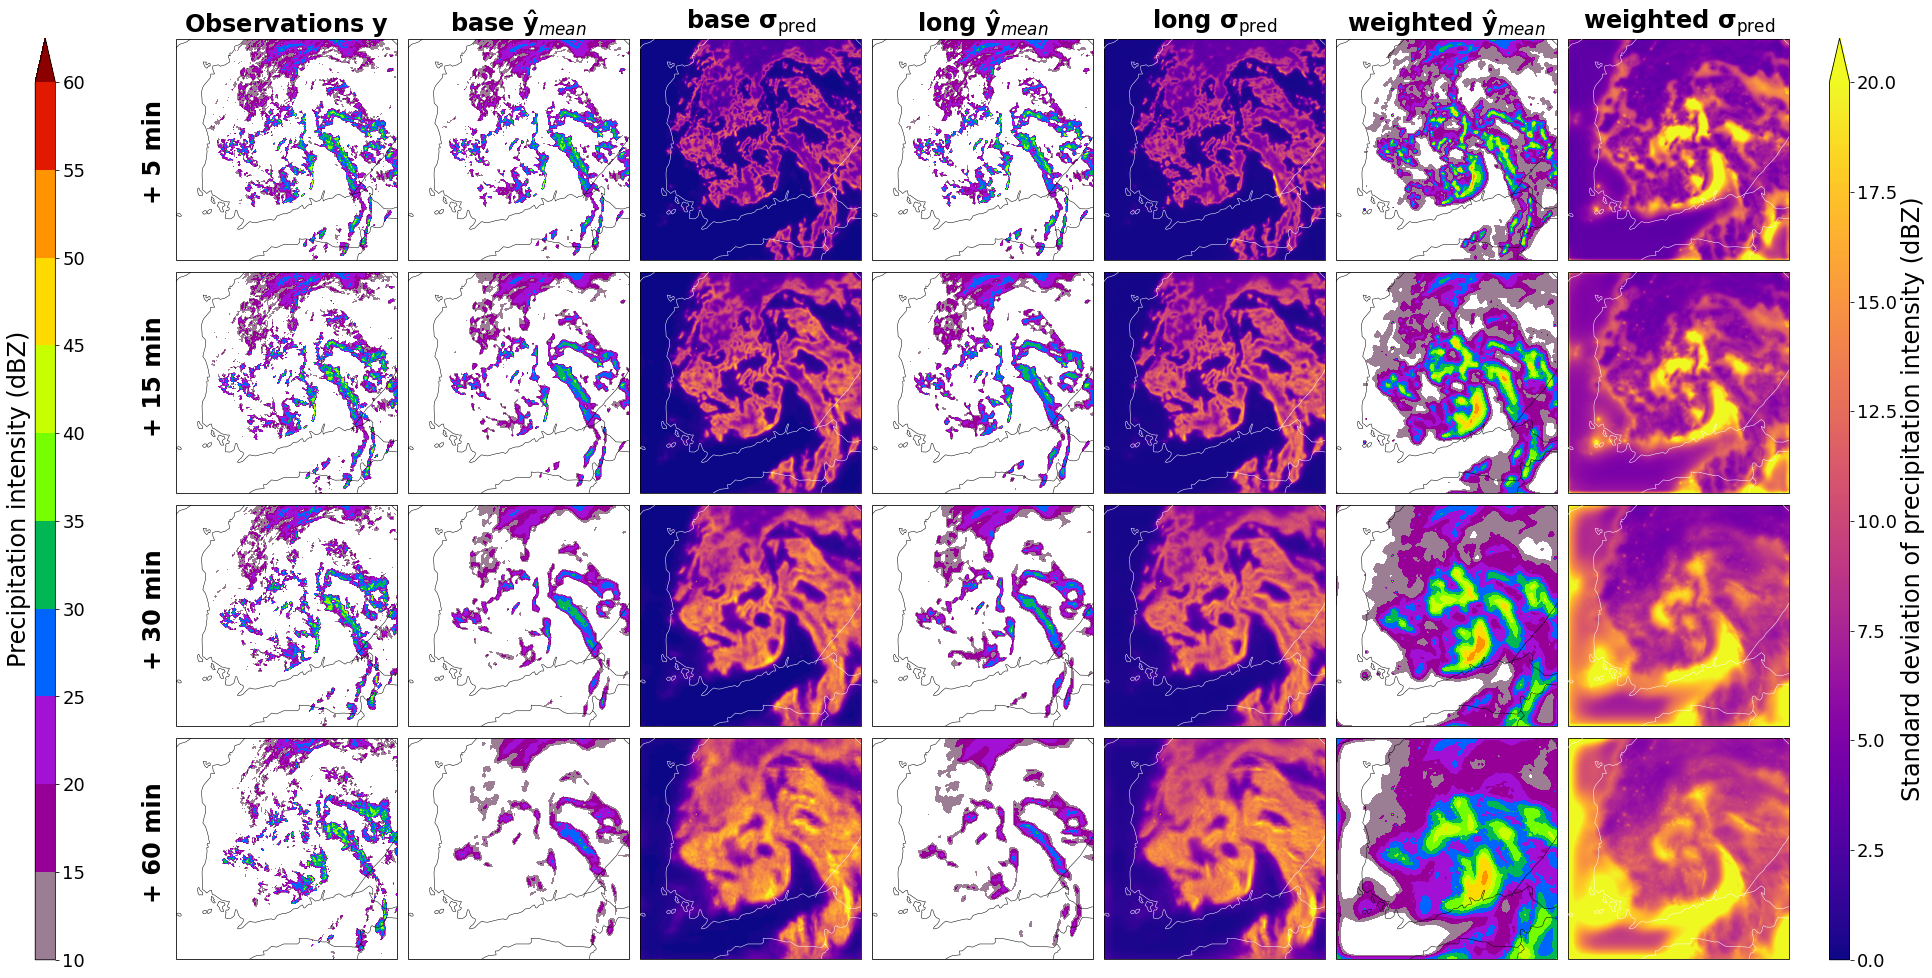

In [13]:
n_stds = 1
fs = 24
fs_tick = 18
cmap, norm, clevs, clevs_str = get_colormap("intensity",units="dBZ", colorscale="pysteps")
cmap_sigma = matplotlib.cm.plasma
cmap_sigma.set_bad('dimgrey',1.)
cmap.set_bad('dimgrey',1.)

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(7*4,4*4), subplot_kw={"projection" : crs})

ax[0,0].set_title("Observations $\mathbf{y}$", fontsize=fs, fontweight="semibold")
ax[0,1].set_title("base $\mathbf{\hat{y}}_{mean}$", fontsize=fs, fontweight="semibold")
ax[0,2].set_title("base $\mathbf{\sigma}_{\mathrm{pred}}$", fontsize=fs, fontweight="semibold")
ax[0,3].set_title("long $\mathbf{\hat{y}}_{mean}$", fontsize=fs, fontweight="semibold")
ax[0,4].set_title("long $\mathbf{\sigma}_{\mathrm{pred}}$", fontsize=fs, fontweight="semibold")
ax[0,5].set_title("weighted $\mathbf{\hat{y}}_{mean}$", fontsize=fs, fontweight="semibold")
ax[0,6].set_title("weighted $\mathbf{\sigma}_{\mathrm{pred}}$", fontsize=fs, fontweight="semibold")

ax[0,0].set_ylabel("+ 5 min")
ax[1,0].set_ylabel("+ 15 min")
ax[2,0].set_ylabel("+ 30 min")
ax[3,0].set_ylabel("+ 60 min")

for i,lt in enumerate([0,2,5,11]):

    for j in range(7):
        ax[i,j].set_extent((x0, x1, y0, y1), crs)
        if j in [2,4,6]:
            edgecolor = "white"
        else:
            edgecolor = "black"
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("physical", "coastline", scale=cartopy_scale,
                edgecolor=edgecolor, facecolor="none", linewidth=0.5), zorder=100)
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("cultural", "admin_0_boundary_lines_land",
                scale=cartopy_scale, edgecolor=edgecolor, facecolor="none", linewidth=0.5),
                zorder=100)

    im_y = ax[i,0].imshow(obses[lt],extent=(x0, x1, y0, y1), cmap=cmap, norm=norm)
    ax[i,1].imshow(deuce_mean[lt],extent=(x0, x1, y0, y1), cmap=cmap, norm=norm)
    ax[i,3].imshow(long_mean[lt],extent=(x0, x1, y0, y1), cmap=cmap, norm=norm)
    ax[i,5].imshow(weight_mean[lt],extent=(x0, x1, y0, y1), cmap=cmap, norm=norm)

    ax[i,2].imshow(deuce_std[lt]*n_stds,extent=(x0, x1, y0, y1), cmap=cmap_sigma, vmin=0.0, vmax=20*n_stds)
    ax[i,4].imshow(long_std[lt]*n_stds,extent=(x0, x1, y0, y1), cmap=cmap_sigma, vmin=0.0, vmax=20*n_stds)
    im_sigma = ax[i,6].imshow(weight_std[lt]*n_stds,extent=(x0, x1, y0, y1), cmap=cmap_sigma, vmin=0.0, vmax=20*n_stds)

ax[0,0].set_ylabel("+ 5 min", fontsize=fs)
#
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0.05,
    hspace=0.05)
    
cbar_sigma_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
cbar_y_ax = fig.add_axes([0.03, 0.1, 0.01, 0.8])

cbar_y = plt.colorbar(
    im_y, ticks=clevs, spacing="uniform", extend="max", pad=0.2, cax=cbar_y_ax
)

if clevs_str is not None:
    cbar_y_ax.set_yticklabels(clevs_str)
    cbar_y_ax.tick_params(labelsize=fs_tick)
#cbar_y.ax.set_title("dBZ", fontsize=14)
cbar_y.set_label(f"Precipitation intensity (dBZ)", fontsize=fs)
cbar_y.ax.yaxis.set_label_position('left')


#cbar_sigma_ax = fig.add_axes([1.01, 0.1, 0.01, 0.8])

cbar_sigma = fig.colorbar(im_sigma, spacing="uniform", extend="max",cax=cbar_sigma_ax)
cbar_sigma.set_label(f"Standard deviation of precipitation intensity (dBZ)", fontsize=fs)
cbar_sigma_ax.tick_params(labelsize=fs_tick)


# leadtime labels
grid = plt.GridSpec(4, 7)
time_x =-0.005
time_y = 0.25
create_subtitle(fig, grid[0,::], '+ 5 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[1,::], '+ 15 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[2,::], '+ 30 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[3,::], '+ 60 min', pos="left", x=time_x, y=time_y, fontsize=fs)

#fig.tight_layout()
#fig.set_size_inches(7*3 + 3,4*3 + 3)
if SAVE:
    fig.savefig(OUTPUT_FOLDER / "case_mean_std.pdf", bbox_inches='tight')